In [7]:
import pyrealsense2 as rs
import open3d as o3d
import matplotlib.pyplot as plt
import numpy as np
import cv2
from scipy.spatial.transform import Rotation as R
import copy
from IPython.display import clear_output
import time

np.set_printoptions(precision=4, suppress=True)

# Saving all frames 

In [8]:
# data filenames
d435_filename = 'data/D435.bag'
t265_filename = 'data/T265.bag'

### T265 (extract key frames, every 220th frame)

In [9]:
# Setup:
cfg = rs.config()
cfg.enable_device_from_file(t265_filename)
cfg.enable_stream(rs.stream.pose)
pipe = rs.pipeline()
profile = pipe.start(cfg)

t265_data_list = []
t265_time_list = []
first_timestamp = None
count = 0
while(True):

    frames = pipe.wait_for_frames()
    pose = frames.get_pose_frame()
    
    if pose:
        if pose.get_timestamp() == first_timestamp:
            print('reached the first frame - reading bag file completed')
            break
        if first_timestamp is None:
            first_timestamp = pose.get_timestamp()
            print('first_timestamp',first_timestamp)
            t265_data_list.append(pose.get_pose_data())
            t265_time_list.append(pose.get_timestamp())
#         print('current-first',pose.get_timestamp()-first_timestamp)
#         t265_data_list.append(pose.get_pose_data())
#         t265_time_list.append(pose.get_timestamp())

        count+=1
        if count%220==0:
            print('current-first',pose.get_timestamp()-first_timestamp)
            t265_data_list.append(pose.get_pose_data())
            t265_time_list.append(pose.get_timestamp())
            
        
pipe.stop()

first_timestamp 1585059273040.0645
current-first 1094.823974609375
current-first 2194.82470703125
current-first 3294.497802734375
current-first 4394.272705078125
current-first 5494.173583984375
current-first 6594.005126953125
current-first 7693.84130859375
current-first 8793.719970703125
current-first 9893.547119140625
current-first 10993.33935546875
current-first 12093.226806640625
current-first 13193.03173828125
current-first 14292.933837890625
current-first 15392.739501953125
current-first 16492.5751953125
current-first 17592.388916015625
current-first 18692.2431640625
current-first 19792.046142578125
current-first 20891.94140625
current-first 21991.758056640625
current-first 23091.640625
current-first 24191.408203125
current-first 25291.20361328125
current-first 26391.15576171875
current-first 27490.9638671875
current-first 28590.75439453125
current-first 29690.663818359375
reached the first frame - reading bag file completed


In [10]:
len(t265_time_list)

28

In [11]:
number_of_key_frames = len(t265_time_list)

### Extract transformations from 265 and plot them in 265 init frame

In [12]:
def get_transformation(data):
#     data = pose.get_pose_data()
    data_rot = [float(i.strip('xyzw: ')) for i in str(data.rotation).split(', ')]
    r = R.from_quat(data_rot)
    rotation = np.array(r.as_matrix())
    translation = np.array([float(i.strip('xyzw: ')) for i in str(data.translation).split(', ')])[np.newaxis].T
    T = np.hstack((rotation, translation))
    T = np.vstack((T, np.array([0, 0, 0, 1])))
    return T

In [13]:
def plot_pose(frames=[], poses=[], show_t=True, show_coord=True, show_pose=True, t_names=['$\mathbf{t}$']):
    """Plotting poses in frames

    Args:
        frames (list): frames to plot in addition to original frame.
        poses (list): poses to plot in the original frame.
        
        show_t (bool): depict t-vector name
        show_coord (bool): depict pose coordinates

    Returns:
        None.
    """
    def get_xyzuvctt(T):
        t = T[:3, 3:4].flatten(); t_ = t/(np.linalg.norm(t)+1e-5)*5
        R = T[:3,:3]
        (x, y, z), (u, v, c) = np.repeat(t.reshape(3,1),3, axis=1), R
        return x, y, z, u, v, c, t, t_
 
    
    fig = plt.figure(figsize=(15,15))
    ax = fig.add_subplot(111, projection='3d')
    lngth = 3

    # fig appearance
    ax.view_init(elev=22, azim=32)
    #ax.set_aspect('equal')
    ax.view_init(elev=22, azim=20)
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.axis('off'); #ax.axis('equal')
    
    
    #origin and coordinate axes (coordinate frame)
    xl = 'x'; yl = 'y'; zl = 'z'; ol = 'O'
    x, y, z, u, v, c, t, t_ = get_xyzuvctt(np.eye(4))
        
    ax.scatter(t_[0], t_[1], t_[2], s=80, c='k')
    ax.quiver(x, y, z, u, v, c, color='k', length=lngth, arrow_length_ratio=0.2, linewidth=0.5)
    ax.text(0,-0.5,-0.1,ol); 
    ax.text(lngth*1.2,0,0,xl); ax.text(0,lngth*1.2,0,yl); ax.text(0,0,lngth*1.2,zl)
    # aid to have initial minimum dimensions of plot
    ax.scatter(4,4,4, alpha=0)
    
    for frame in frames:
        x, y, z, u, v, c, t, t_ = get_xyzuvctt(frame)
        ax.scatter(t_[0], t_[1], t_[2], s=80, c='k')
        ax.quiver(
            x, y, z, u, v, c, color='k', length=lngth, arrow_length_ratio=0.2, linewidth=0.5)
        xl += '\''; yl += '\''; zl += '\''; ol += '\''
        ax.text(t_[0],t_[1]-0.5,t_[2]-0.1,ol); 
        frame = frame @ np.diag([lngth*1.2, lngth*1.2, lngth*1.2, 1])
        ax.text(frame[:3,:3][0][0]+t_[0],frame[:3,:3][1][0]+t_[1], frame[:3,:3][2][0]+t_[2],xl);
        ax.text(frame[:3,:3][0][1]+t_[0],frame[:3,:3][1][1]+t_[1], frame[:3,:3][2][1]+t_[2],yl);
        ax.text(frame[:3,:3][0][2]+t_[0],frame[:3,:3][1][2]+t_[1], frame[:3,:3][2][2]+t_[2],zl);
    
    prev_t = [0, 0, 0]
    for i, pose in enumerate(poses):
        # given frame
        x, y, z, u, v, c, t, t_ = get_xyzuvctt(pose)
        ax.plot([prev_t[0], t[0]], [prev_t[1], t[1]], [prev_t[2], t[2]], color='k', linewidth=2)
        prev_t = t
  
    if show_pose:
            ax.quiver(x, y, z, u, v, c, arrow_length_ratio=0, color=['r','g','b'], linestyle='-', linewidth=4)
    if show_coord:
            ax.text(t[0], t[1], t[2]-0.7, '('+str(t[0])+','+str(t[1])+','+str(t[2])+')')
    
    plt.show()
#     fig.savefig('Path.png')

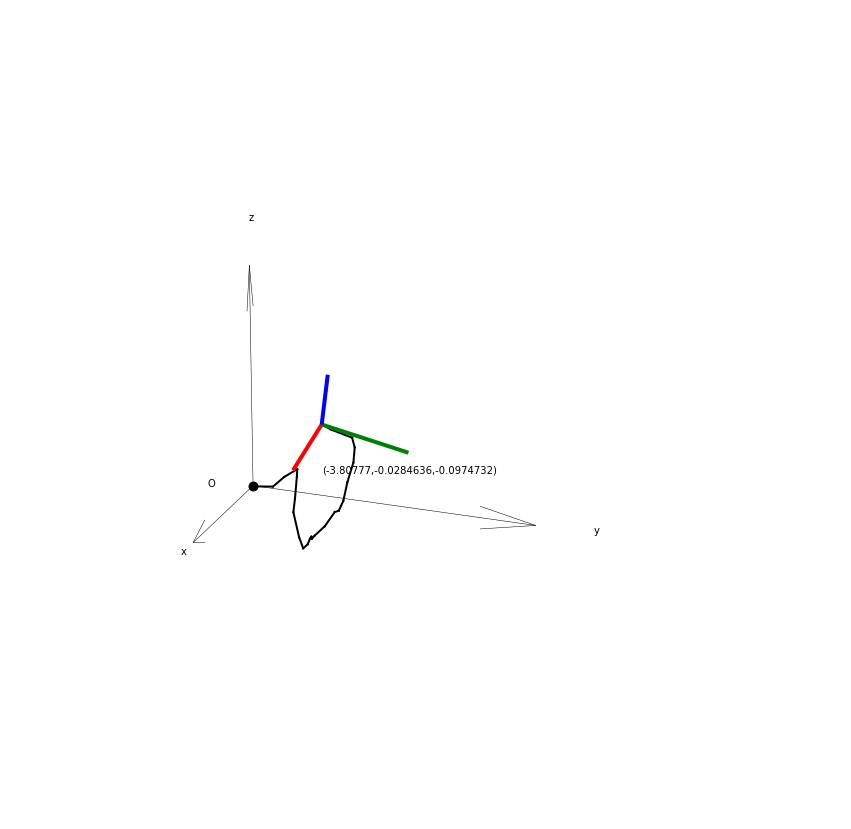

In [14]:
transformation_matrix_set = []
for pose in t265_data_list:
    transformation_matrix_set.append(get_transformation(pose))
    plot_pose(poses=transformation_matrix_set)
    time.sleep(0.01)
    clear_output(wait=True)
plt.show()

### D435i iterate over all frames

In [15]:
# Setup:
cfg = rs.config()
cfg.enable_device_from_file(d435_filename)
cfg.enable_stream(rs.stream.depth, 848, 480, rs.format.z16, 30)
pipe = rs.pipeline()
profile = pipe.start(cfg)

d435_data_list_all = []
d435_time_list_all = []
# a = np.array([])
# l = []
first_timestamp = None
counter = 0
while(True):

    frames = pipe.wait_for_frames()
    depth_frame = frames.get_depth_frame()
#     print('\ndepth_frame.get_timestamp()',depth_frame.get_timestamp())
    
    if depth_frame.get_timestamp() == first_timestamp:
        print('reached the first frame - reading bag file completed')
        print('timestamp',depth_frame.get_timestamp())
        break
    if first_timestamp is None:
        first_timestamp = depth_frame.get_timestamp()
        print('first_timestamp',first_timestamp)
    print('current-first',depth_frame.get_timestamp()-first_timestamp)
    
    d435_data_list_all.append(np.asanyarray(depth_frame.get_data()).copy())
    d435_time_list_all.append(depth_frame.get_timestamp())

cv2.destroyAllWindows()
pipe.stop()

first_timestamp 1585059272738.613
current-first 0.0
current-first 32.364013671875
current-first 65.6904296875
current-first 98.64453125
current-first 131.9052734375
current-first 165.260009765625
current-first 198.619384765625
current-first 231.972412109375
current-first 265.320556640625
current-first 298.669921875
current-first 332.087646484375
current-first 365.589111328125
current-first 398.846923828125
current-first 432.1474609375
current-first 465.772216796875
current-first 498.96435546875
current-first 532.234375
current-first 565.82763671875
current-first 598.99462890625
current-first 632.35302734375
current-first 665.62646484375
current-first 698.97509765625
current-first 732.40380859375
current-first 765.72802734375
current-first 799.047119140625
current-first 832.42724609375
current-first 865.82275390625
current-first 899.141357421875
current-first 932.950927734375
current-first 966.539306640625
current-first 999.246826171875
current-first 1032.65673828125
current-first 1065.

In [16]:
# find the correspondedces between t265_time_list and d435_time_list
d435_data_list = []
d435_time_list = []

for t265timestamp in t265_time_list:
    idx, val = min(enumerate(d435_time_list_all), key=lambda x: abs(x[1]-t265timestamp))
    d435_data_list.append(d435_data_list_all[idx])
    d435_time_list.append(d435_time_list_all[idx])

In [17]:
# just to check
i=27
t265_time_list[i], d435_time_list[i]

(1585059302730.7283, 1585059302722.2495)

In [18]:
len(d435_time_list)

28

### Save key frames from 435

In [19]:
# Setup:
cfg = rs.config()
cfg.enable_device_from_file(d435_filename)
cfg.enable_stream(rs.stream.depth, 848, 480, rs.format.z16, 30)
pipe = rs.pipeline()
profile = pipe.start(cfg)

# d435_data_list_all = []
# d435_time_list_all = []
depth_frame_list = []
# a = np.array([])
# l = []
first_timestamp = None
counter = 0
while(True):

    frames = pipe.wait_for_frames()
    depth_frame = frames.get_depth_frame()
#     print('\ndepth_frame.get_timestamp()',depth_frame.get_timestamp())
    
    if depth_frame.get_timestamp() == first_timestamp:
        print('reached the first frame - reading bag file completed')
        print('timestamp',depth_frame.get_timestamp())
        break
    if first_timestamp is None:
        first_timestamp = depth_frame.get_timestamp()
        print('first_timestamp',first_timestamp)
#     print('current-first',depth_frame.get_timestamp()-first_timestamp)
    
    for d435timestamp in d435_time_list:
        if depth_frame.get_timestamp() == d435timestamp:
            depth_frame_list.append(depth_frame)
            print('current-first',depth_frame.get_timestamp()-first_timestamp)
    
    
#     d435_data_list_all.append(np.asanyarray(depth_frame.get_data()).copy())
#     d435_time_list_all.append(depth_frame.get_timestamp())

cv2.destroyAllWindows()
pipe.stop()

first_timestamp 1585059272738.613
current-first 298.669921875
current-first 1399.471923828125
current-first 2500.16064453125
current-first 3600.828369140625
current-first 4701.559326171875
current-first 5802.134521484375
current-first 6902.9052734375
current-first 8003.4609375
current-first 9104.188720703125
current-first 10204.84912109375
current-first 11306.476318359375
current-first 12406.26318359375
current-first 13506.83984375
current-first 14607.674560546875
current-first 15708.253662109375
current-first 16809.07177734375
current-first 17909.65869140625
current-first 18976.853271484375
current-first 20077.5517578125
current-first 21178.921630859375
current-first 22279.177734375
current-first 23380.199951171875
current-first 24481.905517578125
current-first 25581.21875
current-first 26681.665771484375
current-first 27782.395263671875
current-first 28882.953369140625
current-first 29983.636474609375
reached the first frame - reading bag file completed
timestamp 1585059272738.613


In [20]:
len(depth_frame_list)

28

# Transformations

transformation between cameras

$ {}^{T}T_D$ - d435 wrt t265, always the same

In [21]:
T_d_wrt_t = np.array([[0.999968402, -0.006753626, -0.004188075, -0.015890727],
                      [-0.006685408, -0.999848172, 0.016093893, 0.028273059],
                      [-0.004296131, -0.016065384, -0.999861654, -0.009375589],
                      [0, 0, 0, 1]])

In [22]:
def get_transformation(data):
#     data = pose.get_pose_data()
    data_rot = [float(i.strip('xyzw: ')) for i in str(data.rotation).split(', ')]
    r = R.from_quat(data_rot)
    rotation = np.array(r.as_matrix())
    translation = np.array([float(i.strip('xyzw: ')) for i in str(data.translation).split(', ')])[np.newaxis].T
    T = np.hstack((rotation, translation))
    T = np.vstack((T, np.array([0, 0, 0, 1])))
    return T

In [23]:
relative_transformation_matrix_set = [] # based on 265 = T10,T21,T32, ...
for i in range(len(transformation_matrix_set)-1):
    T_t1_wrt_w = transformation_matrix_set[i]
    T_t2_wrt_w = transformation_matrix_set[i+1]
    T_d1_wrt_w = T_t1_wrt_w @ T_d_wrt_t
    T_d2_wrt_w = T_t2_wrt_w @ T_d_wrt_t
    T_d2_wrt_d1 = np.linalg.inv(T_d1_wrt_w) @ T_d2_wrt_w
    relative_transformation_matrix_set.append(T_d2_wrt_d1)

# Point clouds registration

In [26]:
def get_geom_pcl(depth_frame): #slower
    pc = rs.pointcloud()
    points = pc.calculate(depth_frame).as_points()
    coordinates = np.ndarray(buffer=points.get_vertices(), dtype=np.float32, shape=(480, 848, 3)) \
        .reshape((-1, 3))
    coordinates = coordinates[coordinates[:, 2] != 0]
    pcl = o3d.geometry.PointCloud(o3d.utility.Vector3dVector(coordinates))
    return pcl

In [45]:
icp_relative_transformation_matrix_set=[]
max_point_pair_dist = 0.05
for i in range(len(depth_frame_list)-1):
    pcl1 = get_geom_pcl(depth_frame_list[i])
    pcl2 = get_geom_pcl(depth_frame_list[i+1])
    init = relative_transformation_matrix_set[i]
    T = o3d.registration.registration_icp(pcl2, pcl1, max_point_pair_dist, init)
    print(i, T)
    icp_relative_transformation_matrix_set.append(T.transformation)

0 registration::RegistrationResult with fitness=9.775578e-01, inlier_rmse=1.133334e-02, and correspondence_set size of 356835
Access transformation to get result.
1 registration::RegistrationResult with fitness=8.364449e-01, inlier_rmse=1.762077e-02, and correspondence_set size of 316622
Access transformation to get result.
2 registration::RegistrationResult with fitness=8.333052e-01, inlier_rmse=1.622158e-02, and correspondence_set size of 311037
Access transformation to get result.
3 registration::RegistrationResult with fitness=6.126374e-01, inlier_rmse=1.513926e-02, and correspondence_set size of 238474
Access transformation to get result.
4 registration::RegistrationResult with fitness=7.374620e-01, inlier_rmse=1.441600e-02, and correspondence_set size of 286768
Access transformation to get result.
5 registration::RegistrationResult with fitness=8.075790e-01, inlier_rmse=9.884023e-03, and correspondence_set size of 310414
Access transformation to get result.
6 registration::Regist

### Plot the results and compare (in 435 init frame)

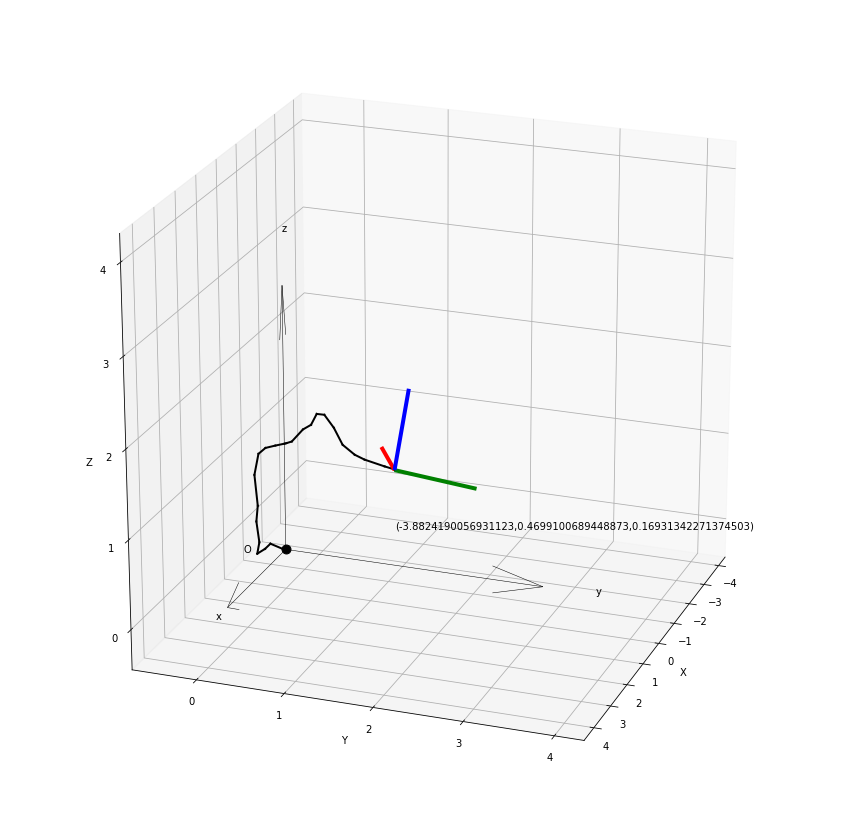

In [46]:
icp_transformation_matrix_set=[]

current_transformation = np.eye(4)

for T in icp_relative_transformation_matrix_set:
    current_transformation = current_transformation @ T
    icp_transformation_matrix_set.append(current_transformation)

    plot_pose(poses=icp_transformation_matrix_set)
    time.sleep(0.01)
    clear_output(wait=True)
plt.show()

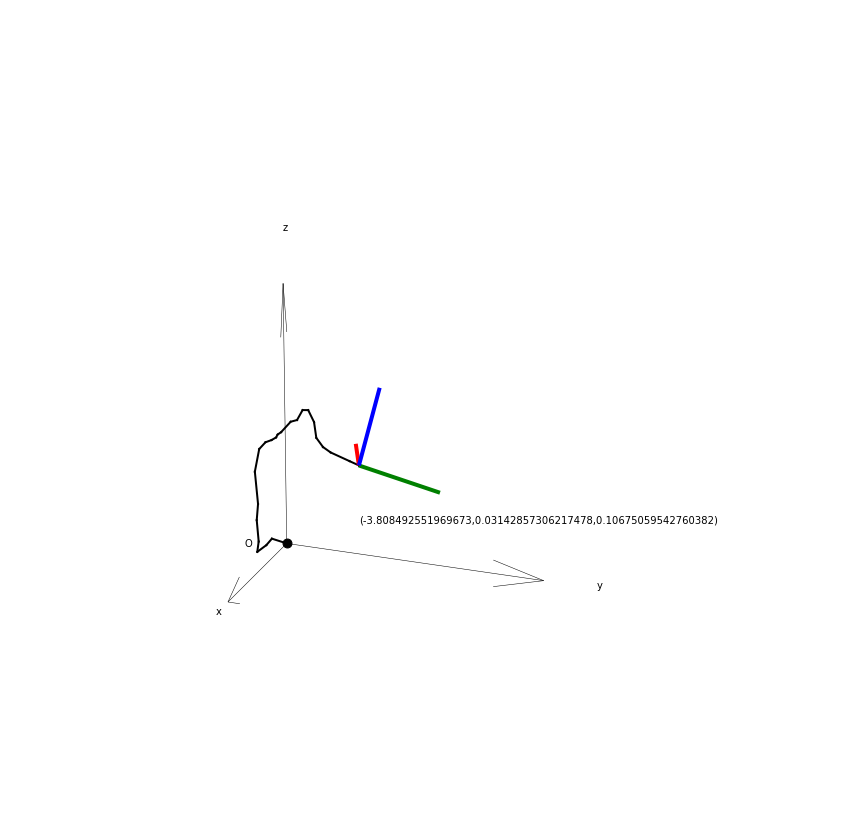

In [29]:
transformation_matrix_set=[]

current_transformation = np.eye(4)

for T in relative_transformation_matrix_set:
    current_transformation = current_transformation @ T
    transformation_matrix_set.append(current_transformation)

    plot_pose(poses=transformation_matrix_set)
    time.sleep(0.01)
    clear_output(wait=True)
plt.show()

In [30]:
t265_traj = np.array([0,0,0])
icp_traj = np.array([0,0,0])

transformation_matrix_set=[]
icp_transformation_matrix_set = []

current_transformation_265 = np.eye(4)
current_transformation_icp = np.eye(4)

for i in range(len(relative_transformation_matrix_set)):
    current_transformation_265 = current_transformation_265 @ relative_transformation_matrix_set[i]
    transformation_matrix_set.append(current_transformation_265)

    current_transformation_icp = current_transformation_icp @ icp_relative_transformation_matrix_set[i]
    icp_transformation_matrix_set.append(current_transformation_icp)
    
    t265_traj = np.hstack((t265_traj, current_transformation_265[:3,-1]))
    icp_traj = np.hstack((icp_traj, current_transformation_icp[:3,-1]))
    
t265_traj = t265_traj.reshape(-1,3)
icp_traj = icp_traj.reshape(-1,3)

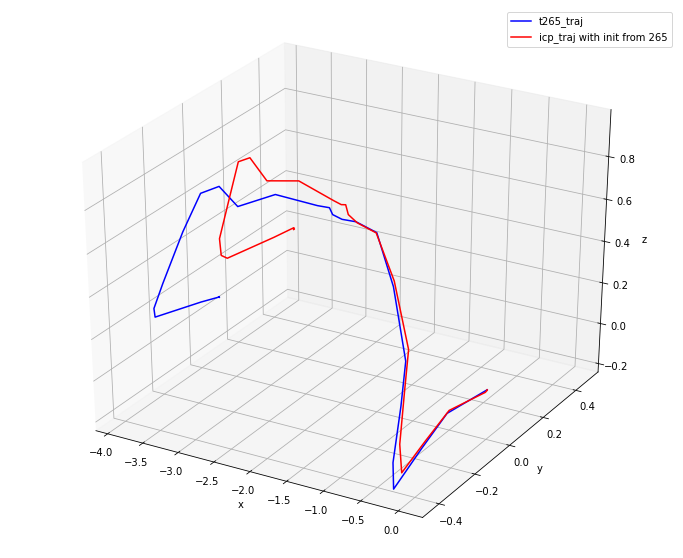

In [31]:
fig = plt.figure()
ax = plt.axes(projection='3d')

ax = plt.axes(projection='3d')

# Data for a three-dimensional line
zline = np.linspace(0, 15, 1000)
xline = np.sin(zline)
yline = np.cos(zline)
ax.plot3D(t265_traj[:,0], t265_traj[:,1], t265_traj[:,2], 'blue',label='t265_traj')
ax.plot3D(icp_traj[:,0], icp_traj[:,1], icp_traj[:,2], 'red', label='icp_traj with init from 265')

ax.legend()
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
fig.set_size_inches(12, 10)

# Debag

In [32]:
i=0

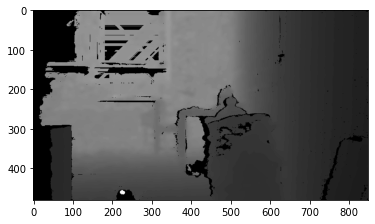

In [33]:
depth_image = np.asanyarray(depth_frame_list[i].get_data())
depth_image = cv2.convertScaleAbs(depth_image, alpha=0.03)
plt.imshow(depth_image, cmap='gray')

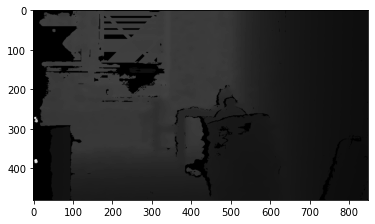

In [34]:
depth_image = np.asanyarray(depth_frame_list[i+1].get_data())
depth_image = cv2.convertScaleAbs(depth_image, alpha=0.03)
plt.imshow(depth_image, cmap='gray')

In [35]:
relative_transformation_matrix_set[i], icp_relative_transformation_matrix_set[i]

(array([[ 1.    ,  0.    ,  0.0041, -0.0002],
        [-0.    ,  1.    ,  0.0006, -0.0006],
        [-0.0041, -0.0006,  1.    , -0.0006],
        [ 0.    ,  0.    ,  0.    ,  1.    ]]),
 array([[ 1.    , -0.0032,  0.0023,  0.0017],
        [ 0.0032,  1.    , -0.0004,  0.0005],
        [-0.0023,  0.0004,  1.    , -0.0015],
        [ 0.    ,  0.    ,  0.    ,  1.    ]]))

### Try to plot on the same plot iteratevely

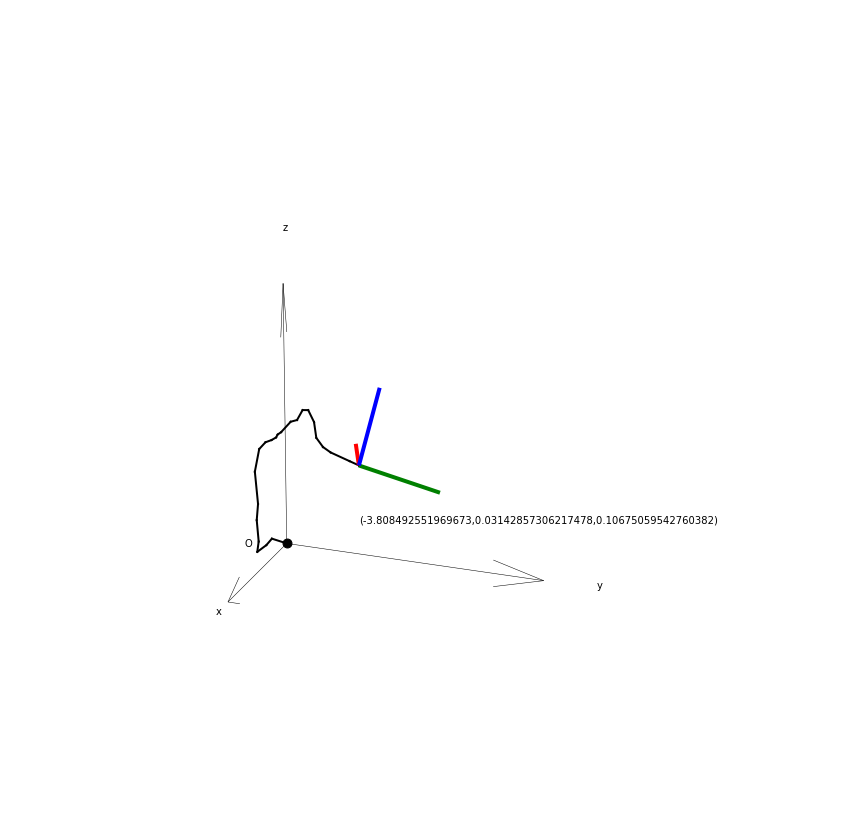

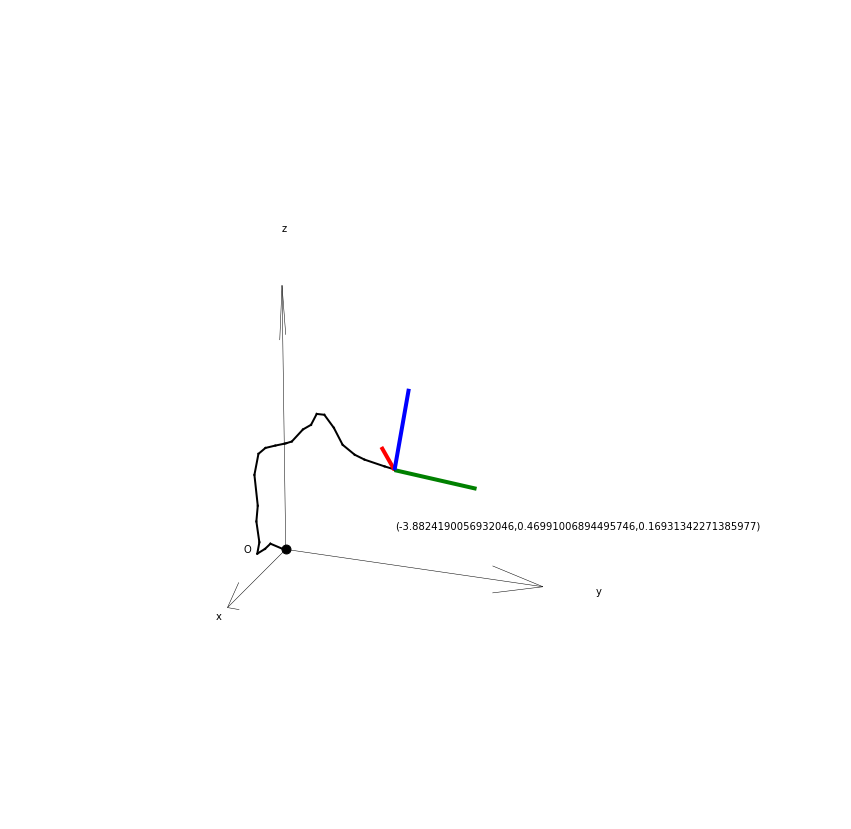

In [38]:
fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(111, projection='3d')
# ax2 = fig.add_subplot(111, projection='3d')

transformation_matrix_set=[]
icp_transformation_matrix_set = []

current_transformation_265 = np.eye(4)
current_transformation_icp = np.eye(4)

for i in range(len(relative_transformation_matrix_set)):
    current_transformation_265 = current_transformation_265 @ relative_transformation_matrix_set[i]
    transformation_matrix_set.append(current_transformation_265)

    current_transformation_icp = current_transformation_icp @ icp_relative_transformation_matrix_set[i]
    icp_transformation_matrix_set.append(current_transformation_icp)
    
    plot_pose(poses=transformation_matrix_set)
    plot_pose(poses=icp_transformation_matrix_set)
    time.sleep(0.01)
    clear_output(wait=True)

plt.show()

In [39]:
def plot_pose(frames=[], poses=[], ax=None, show_t=True, show_coord=True, show_pose=True, t_names=['$\mathbf{t}$']):
    """Plotting poses in frames

    Args:
        frames (list): frames to plot in addition to original frame.
        poses (list): poses to plot in the original frame.
        
        show_t (bool): depict t-vector name
        show_coord (bool): depict pose coordinates

    Returns:
        None.
    """
    def get_xyzuvctt(T):
        t = T[:3, 3:4].flatten(); t_ = t/(np.linalg.norm(t)+1e-5)*5
        R = T[:3,:3]
        (x, y, z), (u, v, c) = np.repeat(t.reshape(3,1),3, axis=1), R
        return x, y, z, u, v, c, t, t_
 
    
    fig = plt.figure(figsize=(15,15))
    ax = fig.add_subplot(111, projection='3d')
    lngth = 3

    # fig appearance
    ax.view_init(elev=22, azim=32)
#     ax.set_aspect('equal')
    ax.view_init(elev=22, azim=20)
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.axis('on'); #ax.axis('equal')
    
    
    #origin and coordinate axes (coordinate frame)
    xl = 'x'; yl = 'y'; zl = 'z'; ol = 'O'
    x, y, z, u, v, c, t, t_ = get_xyzuvctt(np.eye(4))
        
    ax.scatter(t_[0], t_[1], t_[2], s=80, c='k')
    ax.quiver(x, y, z, u, v, c, color='k', length=lngth, arrow_length_ratio=0.2, linewidth=0.5)
    ax.text(0,-0.5,-0.1,ol); 
    ax.text(lngth*1.2,0,0,xl); ax.text(0,lngth*1.2,0,yl); ax.text(0,0,lngth*1.2,zl)
    # aid to have initial minimum dimensions of plot
    ax.scatter(4,4,4, alpha=0)
    
    for frame in frames:
        x, y, z, u, v, c, t, t_ = get_xyzuvctt(frame)
        ax.scatter(t_[0], t_[1], t_[2], s=80, c='k')
        ax.quiver(
            x, y, z, u, v, c, color='k', length=lngth, arrow_length_ratio=0.2, linewidth=0.5)
        xl += '\''; yl += '\''; zl += '\''; ol += '\''
        ax.text(t_[0],t_[1]-0.5,t_[2]-0.1,ol); 
        frame = frame @ np.diag([lngth*1.2, lngth*1.2, lngth*1.2, 1])
        ax.text(frame[:3,:3][0][0]+t_[0],frame[:3,:3][1][0]+t_[1], frame[:3,:3][2][0]+t_[2],xl);
        ax.text(frame[:3,:3][0][1]+t_[0],frame[:3,:3][1][1]+t_[1], frame[:3,:3][2][1]+t_[2],yl);
        ax.text(frame[:3,:3][0][2]+t_[0],frame[:3,:3][1][2]+t_[1], frame[:3,:3][2][2]+t_[2],zl);
    
    prev_t = [0, 0, 0]
    for i, pose in enumerate(poses):
        # given frame
        x, y, z, u, v, c, t, t_ = get_xyzuvctt(pose)
        ax.plot([prev_t[0], t[0]], [prev_t[1], t[1]], [prev_t[2], t[2]], color='k', linewidth=2)
        prev_t = t
  
    if show_pose:
            ax.quiver(x, y, z, u, v, c, arrow_length_ratio=0, color=['r','g','b'], linestyle='-', linewidth=4)
    if show_coord:
            ax.text(t[0], t[1], t[2]-0.7, '('+str(t[0])+','+str(t[1])+','+str(t[2])+')')
    
    plt.show()

## Point-to-plane

In [42]:
icp_plane_relative_transformation_matrix_set=[]
max_point_pair_dist = 0.05
for i in range(len(depth_frame_list)-1):
    pcl3 = get_geom_pcl(depth_frame_list[i])
    pcl4 = get_geom_pcl(depth_frame_list[i+1])
    
    pcl3.estimate_normals(search_param=o3d.geometry.KDTreeSearchParamHybrid(radius=0.1, max_nn=30))
    pcl4.estimate_normals(search_param=o3d.geometry.KDTreeSearchParamHybrid(radius=0.1, max_nn=30))
    init = relative_transformation_matrix_set[i]
    T = o3d.registration.registration_icp(pcl4, pcl3, max_point_pair_dist, init,\
                                          o3d.registration.TransformationEstimationPointToPlane())
    print(i, T)
    icp_plane_relative_transformation_matrix_set.append(T.transformation)

0 registration::RegistrationResult with fitness=9.775167e-01, inlier_rmse=1.133424e-02, and correspondence_set size of 356820
Access transformation to get result.
1 registration::RegistrationResult with fitness=8.303715e-01, inlier_rmse=1.772893e-02, and correspondence_set size of 314323
Access transformation to get result.
2 registration::RegistrationResult with fitness=8.186611e-01, inlier_rmse=1.561583e-02, and correspondence_set size of 305571
Access transformation to get result.
3 registration::RegistrationResult with fitness=6.032657e-01, inlier_rmse=1.446982e-02, and correspondence_set size of 234826
Access transformation to get result.
4 registration::RegistrationResult with fitness=7.164415e-01, inlier_rmse=1.320386e-02, and correspondence_set size of 278594
Access transformation to get result.
5 registration::RegistrationResult with fitness=8.066294e-01, inlier_rmse=9.794885e-03, and correspondence_set size of 310049
Access transformation to get result.
6 registration::Regist

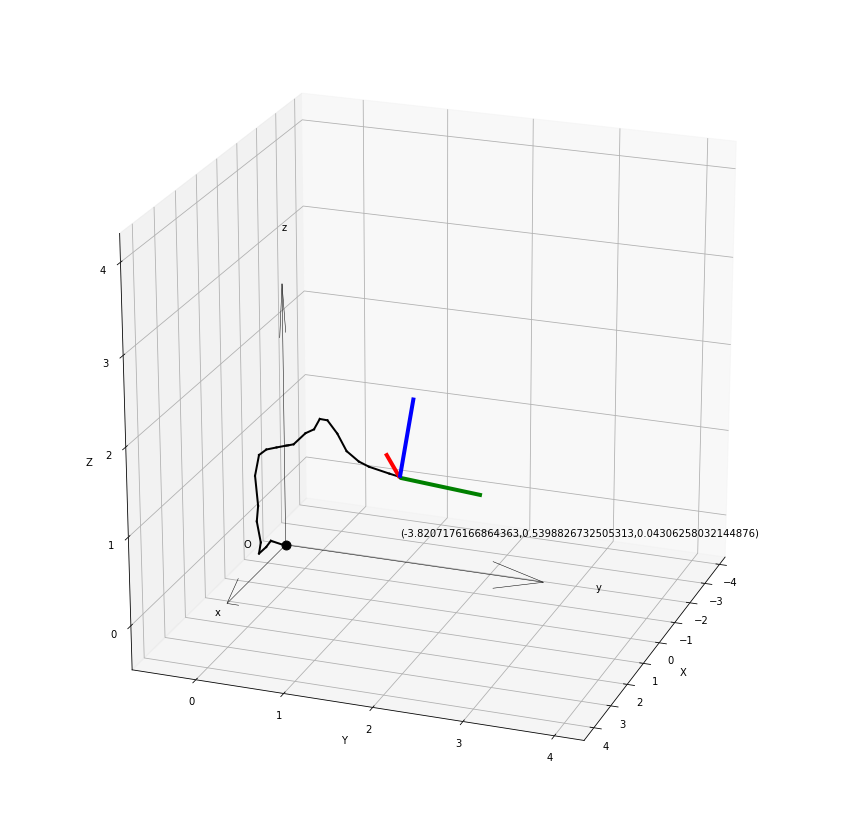

In [44]:
icp_plane_transformation_matrix_set=[]

current_plane_transformation = np.eye(4)

for T in icp_plane_relative_transformation_matrix_set:
    current_plane_transformation = current_plane_transformation @ T
    icp_plane_transformation_matrix_set.append(current_plane_transformation)

    plot_pose(poses=icp_plane_transformation_matrix_set)
    time.sleep(0.01)
    clear_output(wait=True)
plt.show()

In [49]:
t265_traj = np.array([0,0,0])
icp_traj = np.array([0,0,0])
icp_plane_traj = np.array([0,0,0])

transformation_matrix_set=[]
icp_transformation_matrix_set = []
icp_plane_transformation_matrix_set = []

current_transformation_265 = np.eye(4)
current_transformation_icp = np.eye(4)
current_plane_transformation_icp = np.eye(4)

for i in range(len(relative_transformation_matrix_set)):
    current_transformation_265 = current_transformation_265 @ relative_transformation_matrix_set[i]
    transformation_matrix_set.append(current_transformation_265)

    current_transformation_icp = current_transformation_icp @ icp_relative_transformation_matrix_set[i]
    icp_transformation_matrix_set.append(current_transformation_icp)
    
    current_plane_transformation_icp = current_plane_transformation_icp @ icp_plane_relative_transformation_matrix_set[i]
    icp_plane_transformation_matrix_set.append(current_transformation_icp)
    
    t265_traj = np.hstack((t265_traj, current_transformation_265[:3,-1]))
    icp_traj = np.hstack((icp_traj, current_transformation_icp[:3,-1]))
    icp_plane_traj = np.hstack((icp_plane_traj, current_plane_transformation_icp[:3,-1]))
    
t265_traj = t265_traj.reshape(-1,3)
icp_traj = icp_traj.reshape(-1,3)
icp_plane_traj = icp_plane_traj.reshape(-1,3)

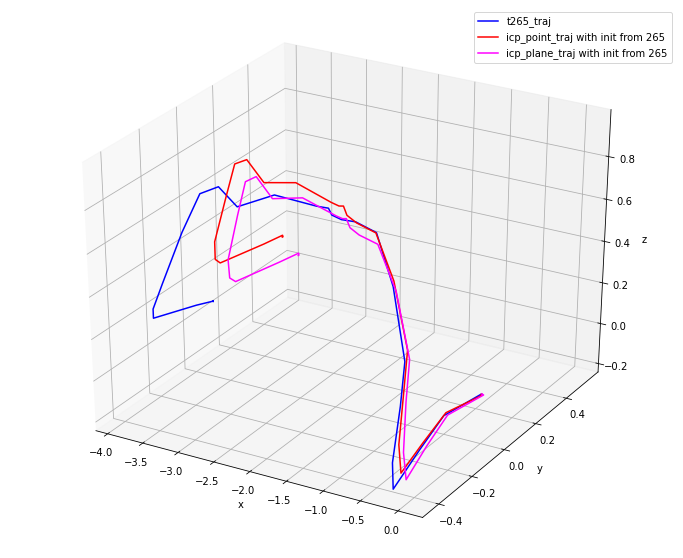

In [50]:
fig = plt.figure()
ax = plt.axes(projection='3d')

ax = plt.axes(projection='3d')

# Data for a three-dimensional line
zline = np.linspace(0, 15, 1000)
xline = np.sin(zline)
yline = np.cos(zline)
ax.plot3D(t265_traj[:,0], t265_traj[:,1], t265_traj[:,2], 'blue',label='t265_traj')
ax.plot3D(icp_traj[:,0], icp_traj[:,1], icp_traj[:,2], 'red', label='icp_point_traj with init from 265')
ax.plot3D(icp_plane_traj[:,0], icp_plane_traj[:,1], icp_plane_traj[:,2], 'magenta', label='icp_plane_traj with init from 265')

ax.legend()
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
fig.set_size_inches(12, 10)

In [ ]:
print("Downsample the point cloud with a voxel of 0.05")
downpcd = pcd.voxel_down_sample(voxel_size=0.05)
o3d.visualization.draw_geometries([downpcd])

In [ ]:
print("Recompute the normal of the downsampled point cloud")
downpcd.estimate_normals(search_param=o3d.geometry.KDTreeSearchParamHybrid(radius=0.1, max_nn=30))
o3d.visualization.draw_geometries([downpcd])

In [ ]:
print("Print a normal vector of the 0th point")
print(downpcd.normals[0])

In [ ]:
print("Print the normal vectors of the first 10 points")
print(np.asarray(downpcd.normals)[:10, :])

In [ ]:
import copy


def draw_registration_result(source, target, transformation):
    source_temp = copy.deepcopy(source)
    target_temp = copy.deepcopy(target)
    source_temp.paint_uniform_color([1, 0.706, 0])
    target_temp.paint_uniform_color([0, 0.651, 0.929])
    source_temp.transform(transformation)
    o3d.visualization.draw_geometries([source_temp, target_temp])


if __name__ == "__main__":
    source = o3d.io.read_point_cloud("../../TestData/ICP/cloud_bin_0.pcd")
    target = o3d.io.read_point_cloud("../../TestData/ICP/cloud_bin_1.pcd")
    threshold = 0.02
    trans_init = np.asarray([[0.862, 0.011, -0.507, 0.5],
                             [-0.139, 0.967, -0.215, 0.7],
                             [0.487, 0.255, 0.835, -1.4], [0.0, 0.0, 0.0, 1.0]])
    draw_registration_result(source, target, trans_init)
    print("Initial alignment")
    evaluation = o3d.registration.evaluate_registration(source, target,
                                                        threshold, trans_init)
    print(evaluation)


    print("Apply point-to-plane ICP")
    reg_p2l = o3d.registration.registration_icp(
        source, target, threshold, trans_init,
        o3d.registration.TransformationEstimationPointToPlane())
    print(reg_p2l)
    print("Transformation is:")
    print(reg_p2l.transformation)
    print("")
    draw_registration_result(source, target, reg_p2l.transformation)

In [6]:
class GeneralizedIterativeClosestPoint:
    """
    Registration class for GeneralizedIterativeClosestPoint
    """
    pcl_reg.GeneralizedIterativeClosestPoint_t *me

    def __cinit__(self):
        self.me = new pcl_reg.GeneralizedIterativeClosestPoint_t()

    def __dealloc__(self):
        del self.me

    def object run(self, pcl_reg.Registration[cpp.PointXYZ, cpp.PointXYZ] &reg, _pcl.PointCloud source, _pcl.PointCloud target, max_iter=None):
        # 1.6.0 NG(No descrription)
        # reg.setInputSource(source.thisptr_shared)
        # PCLBase
        # cdef cpp.PCLBase[cpp.PointXYZ] pclbase
        # NG(Convert)
        # pclbase = reg
        # pclbase = <cpp.PCLBase> reg
        # pclbase = <cpp.PCLBase[cpp.PointXYZ]> reg
        # pclbase.setInputCloud(source.thisptr_shared)
        # pclbase.setInputCloud(<cpp.PointCloudPtr_t> source.thisptr_shared)
        # set PointCloud?
        # get InputCloud?
        # reg.setInputCloud(<cpp.PointCloudPtr_t> pclbase.getInputCloud())
        reg.setInputTarget(target.thisptr_shared)
        
        if max_iter is not None:
            reg.setMaximumIterations(max_iter)
        
        cdef _pcl.PointCloud result = _pcl.PointCloud()
        
        with nogil:
            reg.align(result.thisptr()[0])
        
        # Get transformation matrix and convert from Eigen to NumPy format.
        # cdef pcl_reg.Registration[cpp.PointXYZ, cpp.PointXYZ].Matrix4f mat
        cdef Matrix4f mat
        mat = reg.getFinalTransformation()
        cdef np.ndarray[dtype=np.float32_t, ndim=2, mode='fortran'] transf
        cdef np.float32_t *transf_data
        
        transf = np.empty((4, 4), dtype=np.float32, order='fortran')
        transf_data = <np.float32_t *>np.PyArray_DATA(transf)
        
        for i in range(16):
            transf_data[i] = mat.data()[i]
        
        return reg.hasConverged(), transf, result, reg.getFitnessScore()

    def gicp(self, _pcl.PointCloud source, _pcl.PointCloud target, max_iter=None):
        """
        Align source to target using generalized iterative closest point (GICP).
        
        Parameters
        ----------
        source : PointCloud
            Source point cloud.
        target : PointCloud
            Target point cloud.
        max_iter : integer, optional
            Maximum number of iterations. If not given, uses the default number
            hardwired into PCL.
        
        Returns
        -------
        converged : bool
            Whether the ICP algorithm converged in at most max_iter steps.
        transf : np.ndarray, shape = [4, 4]
            Transformation matrix.
        estimate : PointCloud
            Transformed version of source.
        fitness : float
            Sum of squares error in the estimated transformation.
        """
        cdef pcl_reg.GeneralizedIterativeClosestPoint[cpp.PointXYZ, cpp.PointXYZ] gicp
        gicp.setInputCloud(source.thisptr_shared)
        return self.run(gicp, source, target, max_iter)


SyntaxError: invalid syntax (<ipython-input-6-9dc790284853>, line 8)

transformation of t265 wrt world

$ {}^{W}T_{T}$

In [60]:
#frame1
T_t1_wrt_w = get_transformation(t265_frame1_data)
T_t1_wrt_w

array([[ 0.9583, -0.2281,  0.1724, -2.6506],
       [ 0.1038,  0.8393,  0.5337,  0.3914],
       [-0.2664, -0.4935,  0.8279, -0.9613],
       [ 0.    ,  0.    ,  0.    ,  1.    ]])

In [61]:
#frame2
T_t2_wrt_w = get_transformation(t265_frame2_data)
T_t2_wrt_w

array([[ 0.9969, -0.0675, -0.0393, -2.8294],
       [ 0.0777,  0.8075,  0.5847,  0.3957],
       [-0.0077, -0.5859,  0.8103, -0.933 ],
       [ 0.    ,  0.    ,  0.    ,  1.    ]])

transformation of d435 wrt world

$ {}^{W}T_{D1} = {}^{W}T_{T} {}^{T}T_{D1}$

In [62]:
#frame1
T_d1_wrt_w = T_t1_wrt_w @ T_d_wrt_t
T_d1_wrt_w

array([[ 0.959 ,  0.2189, -0.18  , -2.6739],
       [ 0.0959, -0.8484, -0.5206,  0.4085],
       [-0.2667,  0.482 , -0.8346, -0.9788],
       [ 0.    ,  0.    ,  0.    ,  1.    ]])

$ {}^{W}T_{D2} = {}^{W}T_{T} {}^{T}T_{D2}$

In [63]:
#frame2
T_d2_wrt_w = T_t2_wrt_w @ T_d_wrt_t
T_d2_wrt_w

array([[ 0.9975,  0.0613,  0.0341, -2.8468],
       [ 0.0698, -0.8173, -0.5719,  0.4118],
       [-0.0072,  0.5729, -0.8196, -0.9571],
       [ 0.    ,  0.    ,  0.    ,  1.    ]])

transformation of keyframe2 wrt keyframe1

$ {}^{W}T_{D2} = {}^{W}T_{D1} {}^{D1}T_{D2}$

$ ({}^{W}T_{D1})^{-1} {}^{W}T_{D2} = {}^{D1}T_{D2}$

${}^{D1}T_{D2}$:

In [64]:
# keyframe 2 wtr keyframe 1
T_d2_wrt_d1 = np.linalg.inv(T_d1_wrt_w) @ T_d2_wrt_w
T_d2_wrt_d1

array([[ 0.9653, -0.1723,  0.1964, -0.1712],
       [ 0.1556,  0.983 ,  0.0976, -0.0302],
       [-0.2099, -0.0637,  0.9757,  0.0113],
       [ 0.    ,  0.    ,  0.    ,  1.    ]])

Now let's try to get ${}^{D1}T_{D2}$ from point cloud registration

# Point clouds registration

### Defive PC, init, and max_point_pair_dist

In [88]:
def get_geom_pcl(depth_frame): #slower
    pc = rs.pointcloud()
    points = pc.calculate(depth_frame).as_points()
    coordinates = np.ndarray(buffer=points.get_vertices(), dtype=np.float32, shape=(480, 848, 3)) \
        .reshape((-1, 3))
    coordinates = coordinates[coordinates[:, 2] != 0]
    pcl = o3d.geometry.PointCloud(o3d.utility.Vector3dVector(coordinates))
    return pcl

In [89]:
import copy
def draw_registration_result(source, target, transformation):
    source_temp = copy.deepcopy(source)
    target_temp = copy.deepcopy(target)
    source_temp.paint_uniform_color([1, 0.706, 0])
    target_temp.paint_uniform_color([0, 0.651, 0.929])
    source_temp.transform(transformation)
    o3d.visualization.draw_geometries([source_temp, target_temp])

In [91]:
# Setup:
cfg = rs.config()
cfg.enable_device_from_file(d435_filename)
cfg.enable_stream(rs.stream.depth, 848, 480, rs.format.z16, 30)
pipe = rs.pipeline()
profile = pipe.start(cfg)

d435_data_list = []
d435_time_list = []
# a = np.array([])
# l = []
first_timestamp = None
counter = 0
while(True):

    frames = pipe.wait_for_frames()
    depth_frame = frames.get_depth_frame()
#     print('\ndepth_frame.get_timestamp()',depth_frame.get_timestamp())
    
    if depth_frame.get_timestamp() == first_timestamp:
        print('reached the first frame - reading bag file completed')
        print('timestamp',depth_frame.get_timestamp())
        break
    if first_timestamp is None:
        first_timestamp = depth_frame.get_timestamp()
        print('first_timestamp',first_timestamp)
    print('current-first',depth_frame.get_timestamp()-first_timestamp)
    
    
    
    # to do it first go and find timestampsmof key frames
    if depth_frame.get_timestamp() == 1585059293016.778:
        depth_frame1 = depth_frame
    if depth_frame.get_timestamp() == 1585059293549.9937:
        depth_frame2 = depth_frame
    
    
#     depth_image = np.asanyarray(depth_frame.get_data())
#     depth_image = cv2.convertScaleAbs(depth_image, alpha=0.03)
#     cv2.imshow('D435 Depth Frame', depth_image)
#     cv2.waitKey(1)
    
#     counter+=1
#     if counter%30==0:
#         a = np.hstack((a, depth_frame))
#         l.append(depth_frame)
    
    d435_data_list.append(np.asanyarray(depth_frame.get_data()).copy())
    d435_time_list.append(depth_frame.get_timestamp())

cv2.destroyAllWindows()
pipe.stop()

first_timestamp 1585059272738.613
current-first 0.0
current-first 32.364013671875
current-first 65.6904296875
current-first 98.64453125
current-first 131.9052734375
current-first 165.260009765625
current-first 198.619384765625
current-first 231.972412109375
current-first 265.320556640625
current-first 298.669921875
current-first 332.087646484375
current-first 365.589111328125
current-first 398.846923828125
current-first 432.1474609375
current-first 465.772216796875
current-first 498.96435546875
current-first 532.234375
current-first 565.82763671875
current-first 598.99462890625
current-first 632.35302734375
current-first 665.62646484375
current-first 698.97509765625
current-first 732.40380859375
current-first 765.72802734375
current-first 799.047119140625
current-first 832.42724609375
current-first 865.82275390625
current-first 899.141357421875
current-first 932.950927734375
current-first 966.539306640625
current-first 999.246826171875
current-first 1032.65673828125
current-first 1065.

In [92]:
%%time
pcl1 = get_geom_pcl(depth_frame1)
pcl2 = get_geom_pcl(depth_frame2)

Wall time: 1.22 s


In [62]:
init = T_d2_wrt_d1 # does not help much ?

In [63]:
max_point_pair_dist = 0.02

### Evaliate init guess

In [95]:
evaluation_init = o3d.registration.evaluate_registration(pcl2, pcl1,
                                                    max_point_pair_dist, init)
evaluation_init

registration::RegistrationResult with fitness=1.492532e-01, inlier_rmse=1.249152e-02, and correspondence_set size of 54738
Access transformation to get result.

In [96]:
draw_registration_result(pcl2, pcl1, init)

### Evaluate ICP

#### With $init = Identity$

In [116]:
%%time
T = o3d.registration.registration_icp(pcl2, pcl1, max_point_pair_dist)
T, T.transformation

Wall time: 7.32 s


(registration::RegistrationResult with fitness=3.952408e-01, inlier_rmse=9.151465e-03, and correspondence_set size of 144953
 Access transformation to get result.,
 array([[ 0.9993, -0.0345,  0.0135, -0.0092],
        [ 0.034 ,  0.9988,  0.0341,  0.0039],
        [-0.0147, -0.0336,  0.9993,  0.0251],
        [ 0.    ,  0.    ,  0.    ,  1.    ]]))

In [117]:
draw_registration_result(pcl2, pcl1, T.transformation)

#### With $init = {}^{D1}T_{D2}$

In [118]:
%%time
T_init = o3d.registration.registration_icp(pcl2, pcl1, max_point_pair_dist, init)
T_init, T_init.transformation

Wall time: 7.56 s


(registration::RegistrationResult with fitness=3.974413e-01, inlier_rmse=9.712176e-03, and correspondence_set size of 145760
 Access transformation to get result.,
 array([[ 0.999 , -0.0391,  0.0224, -0.0169],
        [ 0.039 ,  0.9992,  0.0069,  0.0209],
        [-0.0227, -0.006 ,  0.9997,  0.0272],
        [ 0.    ,  0.    ,  0.    ,  1.    ]]))

In [119]:
draw_registration_result(pcl2, pcl1, T_init.transformation)

In [124]:
pcl3 = copy.deepcopy(pcl1)
pcl4 = copy.deepcopy(pcl2)

In [125]:
%%time

pcl3.estimate_normals(search_param=o3d.geometry.KDTreeSearchParamHybrid(radius=0.1, max_nn=30))
pcl4.estimate_normals(search_param=o3d.geometry.KDTreeSearchParamHybrid(radius=0.1, max_nn=30))

init = relative_transformation_matrix_set[i]
T_plane = o3d.registration.registration_icp(pcl4, pcl3, max_point_pair_dist, np.eye(4),\
                                          o3d.registration.TransformationEstimationPointToPlane())
T_plane, T_plane.transformation

Wall time: 7.93 s


(registration::RegistrationResult with fitness=5.891843e-01, inlier_rmse=9.251151e-03, and correspondence_set size of 216081
 Access transformation to get result.,
 array([[ 0.9787, -0.1365,  0.1531, -0.1385],
        [ 0.126 ,  0.9891,  0.0764, -0.0135],
        [-0.1618, -0.0555,  0.9853,  0.0132],
        [ 0.    ,  0.    ,  0.    ,  1.    ]]))

In [126]:
%%time

init = relative_transformation_matrix_set[i]
T_plane_init = o3d.registration.registration_icp(pcl4, pcl3, max_point_pair_dist, init,\
                                          o3d.registration.TransformationEstimationPointToPlane())
T_plane_init,T_plane_init.transformation

Wall time: 7 s


(registration::RegistrationResult with fitness=5.124555e-01, inlier_rmse=9.165712e-03, and correspondence_set size of 187941
 Access transformation to get result.,
 array([[ 0.9845, -0.118 ,  0.1297, -0.117 ],
        [ 0.1098,  0.9916,  0.0681, -0.0103],
        [-0.1367, -0.0528,  0.9892,  0.0147],
        [ 0.    ,  0.    ,  0.    ,  1.    ]]))

# Results

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


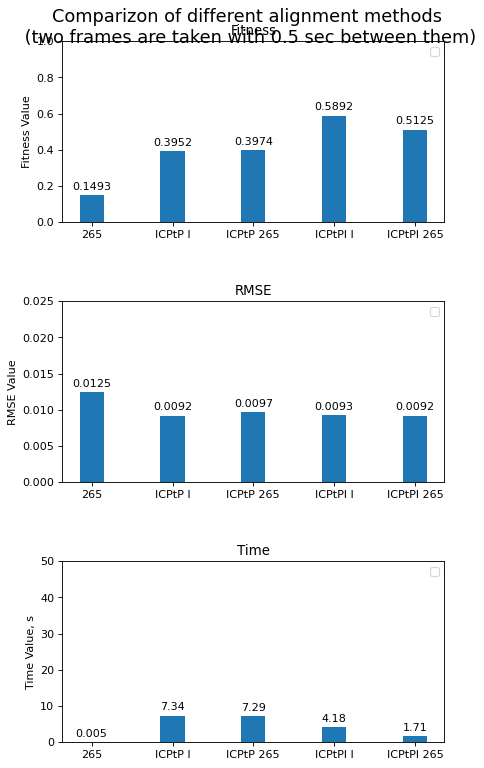

In [128]:
fitness_list =  [evaluation_init.fitness, T.fitness, T_init.fitness, T_plane.fitness, T_plane_init.fitness ]
rmse_list =  [evaluation_init.inlier_rmse, T.inlier_rmse, T_init.inlier_rmse, T_plane.inlier_rmse, T_plane_init.inlier_rmse]
time_list =  [0.005, 7.34, 7.29,4.18,1.71 ]
labels =  [ '265', 'ICPtP I', 'ICPtP 265',\
           'ICPtPl I','ICPtPl 265']
x = np.arange(len(labels))  # the label locations
width = 0.3  # the width of the bars

fig, (ax0, ax, ax2) = plt.subplots(3,1,figsize = (20,6), dpi = 80)

fig.suptitle('Comparizon of different alignment methods\n (two frames are taken with 0.5 sec between them)\n ', fontsize=16)
rects0 = ax0.bar(x, fitness_list, width)
rects1 = ax.bar(x, rmse_list, width)
rects2 = ax2.bar(x, time_list, width)

# Add some text for labels, title and custom x-axis tick labels, etc.
ax0.set_ylabel('Fitness Value')
ax0.set_title('Fitness')
ax0.set_xticks(x)
ax0.set_xticklabels(labels)
ax0.legend()
ax0.set_ylim([0,1])

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('RMSE Value')
ax.set_title('RMSE')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()
ax.set_ylim([0,0.025])

# Add some text for labels, title and custom x-axis tick labels, etc.
ax2.set_ylabel('Time Value, s')
ax2.set_title('Time')
ax2.set_xticks(x)
ax2.set_xticklabels(labels)
ax2.legend()
ax2.set_ylim([0,50])

def autolabel(rects, ax):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = round(rect.get_height(),4)
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects0, ax0)
autolabel(rects1, ax)
autolabel(rects2, ax2)

fig.tight_layout()
fig.set_size_inches(5, 10)

plt.show()

In [ ]:
# rewind
for i in range(frames_between_frames_D435*count_of_frames*2):
    pipe_d435.wait_for_frames()

In [ ]:
d435_frames = []
while len(d435_frames) != count_of_frames:
    for i in range(frames_between_frames_D435):
        depth_frame = pipe_d435.wait_for_frames().get_depth_frame()
    d435_frames.append(depth_frame)

In [ ]:
pose_frame = None
pose_frame_time = -1
thresh = 7
t265_frames = []
t265_frames_temp = []
n = 0

for i, depth_frame in enumerate(d435_frames):
    depth_frame_time = depth_frame.get_timestamp()
    while abs(depth_frame_time-pose_frame_time) > thresh:
        pose_frame = pipe_t265.wait_for_frames().get_pose_frame()
        pose_frame_time = pose_frame.get_timestamp()
    while abs(depth_frame_time-pose_frame_time) <= thresh:
        pose_frame = pipe_t265.wait_for_frames().get_pose_frame()
        t265_frames_temp.append(pose_frame)
        pose_frame_time = pose_frame.get_timestamp()

    min_int_index = 0
    min_interval = thresh * 2
    for ind_pose, temp_pose in enumerate(t265_frames_temp):
        if abs(depth_frame_time-temp_pose.get_timestamp())<min_interval:
            min_interval = abs(depth_frame_time-temp_pose.get_timestamp())
            min_int_index = ind_pose
    t265_frames.append(t265_frames_temp[min_int_index])
    

## Test for frames

In [ ]:
def count_diff_frames(frames):
    prev_frame = None
    for i, frame in enumerate(frames):
        if prev_frame is not None:
            print("Difference bw {0} and {1} frames is {2:.4f} ms".format(i, i-1, frame.get_timestamp()-prev_frame.get_timestamp()))
        prev_frame = frame

In [ ]:
def get_diff_sensors(frames1, frames2):
    if len(frames1) != len(frames2):
        return
    else:
        for i in range(len(frames1)):
            print("Difference bw frames1[{0}] and frames2[{0}] frames is {1:.4f} ms".format(i, frames1[i].get_timestamp()-frames2[i].get_timestamp()))
        

In [ ]:
count_diff_frames(d435_frames)
count_diff_frames(t265_frames)

In [ ]:
get_diff_sensors(d435_frames, t265_frames)

# Analysis

## Helpers

In [ ]:
import time
from functools import wraps

def timing(f):
    @wraps(f)
    def wrap(*args, **kw):
        time_start = time.time()
        result = f(*args, **kw)
        time_end = time.time()
        print('----------func:%r took: %2.4f sec' % (f.__name__, time_end-time_start))
        return result
    return wrap

In [ ]:
tm_T265toD435 = np.array([[0.999968402, -0.006753626, -0.004188075, -0.015890727],
                          [-0.006685408, -0.999848172, 0.016093893, 0.028273059],
                          [-0.004296131, -0.016065384, -0.999861654, -0.009375589],
                          [0, 0, 0, 1]])

In [ ]:
# Graph plot
t265 = np.load('../logs/points_trajectory_T265.npy') #np array coords
d435 = np.load('../logs/points_trajectory_D435.npy')/1 # np array coords
# before = 10
before = d435.shape[0]
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.plot(t265[:before, 0], t265[:before, 1], t265[:before, 2], label='t265')
ax.plot(d435[:before, 0], d435[:before, 1], d435[:before, 2], label='d435')
ax.view_init(elev=22, azim=80)
plt.legend()

## Functions

In [ ]:
def get_transformation(pose):
    data = pose.get_pose_data()
    data_rot = [float(i.strip('xyzw: ')) for i in str(data.rotation).split(', ')]
    r = R.from_quat(data_rot)
    rotation = np.array(r.as_matrix())
    translation = np.array([float(i.strip('xyzw: ')) for i in str(data.translation).split(', ')])[np.newaxis].T
    T = np.hstack((rotation, translation))
    T = np.vstack((T, np.array([0, 0, 0, 1])))
    return T

In [ ]:
get_transformation(t265_frames[0])

In [ ]:
def apply_transformation(transformation, points):
    """

    :param transformation: 4x4 np.array
    :param points: Nx3 np.array
    :return: transformed Nx3 np.array
    """
    if transformation is None or points is None:
        return None
    else:
        coordinates = np.hstack((points, np.ones((points.shape[0], 1))))
        return (transformation @ coordinates.T).T[:, :-1]

In [ ]:
def get_coordinates(depth_frame, make_sampling=True, koef = 2**2):
    """
     TODO
    :param make_sampling:
    :return:
    """
    pc = rs.pointcloud()
    if make_sampling:
        decimate = rs.decimation_filter()
        decimate.set_option(rs.option.filter_magnitude, koef)
        depth_frame = decimate.process(depth_frame)

        points = pc.calculate(depth_frame).as_points()
    else:
        points = pc.calculate(depth_frame).as_points()

    coordinates = np.ndarray(buffer=points.get_vertices(), dtype=np.float32, shape=(points.size(), 3))
    coordinates = coordinates[coordinates[:, 2] != 0]

    coordinates = apply_transformation(tm_T265toD435, coordinates)
    return coordinates


In [ ]:
get_coordinates(d435_frames[0]).shape

In [ ]:
def convert_to_pcl(points):
    """
        TODO
    :param points: Nx3
    :return:
    """
    if points is None:
        return None
    else:
        return o3d.geometry.PointCloud(o3d.utility.Vector3dVector(points))

In [ ]:
convert_to_pcl(get_coordinates(d435_frames[0]))

In [ ]:
# TODO this 100%

def get_transformation(self, max_point_pair_dist=0.2, init_guess=np.eye(4)):
    old_point_cloud = self.apply_transformation(self.prev_tm, self.point_cloud)
    old_pcl = self.convert_to_pcl(old_point_cloud) # n-1
    self.point_cloud = self.apply_transformation(self.prev_tm, self.get_coordinates())
    if old_pcl is None:
        self.prev_tm = init_guess
        print("\n\n\n{}\n\n\n".format(init_guess))
        return None

    new_pcl = self.convert_to_pcl(self.point_cloud) # n

    tr_mx = o3d.registration.registration_icp(old_pcl, new_pcl, max_point_pair_dist,
                                              self.prev_tm, o3d.registration.TransformationEstimationPointToPoint())\
        .transformation
    self.prev_tm = tr_mx
    return tr_mx